In [1]:
import torch
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import itertools
import pdb
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import sys

sys.path.insert(0, './src')

from data import Dataset
from kernels import HMC_our, HMC_vanilla
from models import Gen_network, Inf_network
from target import NN_bernoulli
from utils import plot_digit_samples, get_samples
from args import get_args
import pyro
from pyro.distributions.transforms import AffineAutoregressive
from pyro.nn import AutoRegressiveNN

In [2]:
args = get_args()

In [3]:
dataset = Dataset(args, device=args.device)

In [4]:
encoder = Inf_network(args).to(args.device)
target = NN_bernoulli(kwargs=args, model=Gen_network(args.z_dim, args), device=args.device).to(args.device)
HMC = HMC_vanilla(args)
# IAF = nn.ModuleList([AffineAutoregressive(AutoRegressiveNN(args['z_dim'], [384])).to(device) for _ in range(K)])

In [5]:
params = [encoder.parameters()] #, IAF.parameters()]
optimizer_phi = torch.optim.Adam(params=itertools.chain(*params))
optimizer_theta = torch.optim.Adam(params=target.parameters())

In [6]:
mask_distr = torch.distributions.Uniform(torch.tensor(0.0, device=args.device),
                                                      torch.tensor(1.0, device=args.device))

In [7]:
random_code = args.std_normal.sample((64, args.z_dim))

  0%|          | 0/400 [00:00<?, ?it/s]

obj_1: -199.16323852539062
obj_2: -286.8800354003906
Saved samples to ./pics/mnist_epoch_None_K_2_N_2_amortize_True.png


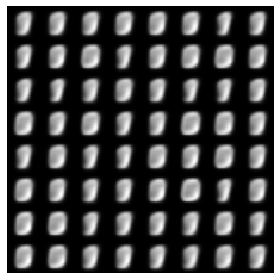

  0%|          | 1/400 [00:20<2:18:18, 20.80s/it]

obj_1: -184.24636840820312
obj_2: -264.97625732421875
Saved samples to ./pics/mnist_epoch_None_K_2_N_2_amortize_True.png


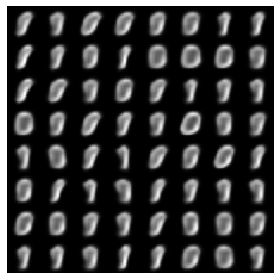

  0%|          | 2/400 [00:41<2:17:34, 20.74s/it]

obj_1: -149.494140625
obj_2: -224.9366912841797
Saved samples to ./pics/mnist_epoch_None_K_2_N_2_amortize_True.png


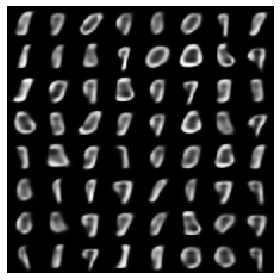

  1%|          | 3/400 [01:02<2:16:59, 20.70s/it]

obj_1: -136.61209106445312
obj_2: -203.28985595703125
Saved samples to ./pics/mnist_epoch_None_K_2_N_2_amortize_True.png


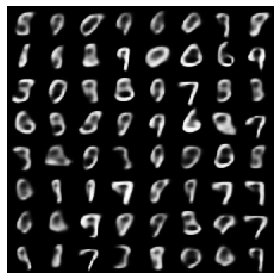

  1%|          | 4/400 [01:22<2:16:28, 20.68s/it]

obj_1: -124.10169982910156
obj_2: -189.57254028320312
Saved samples to ./pics/mnist_epoch_None_K_2_N_2_amortize_True.png


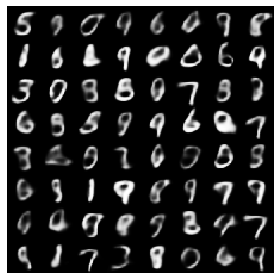

  1%|▏         | 5/400 [01:43<2:15:59, 20.66s/it]

obj_1: -131.99375915527344
obj_2: -192.03466796875
Saved samples to ./pics/mnist_epoch_None_K_2_N_2_amortize_True.png


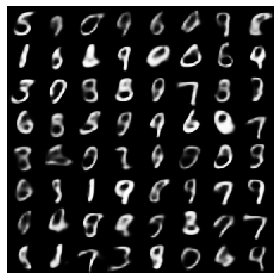

  2%|▏         | 6/400 [02:03<2:15:46, 20.68s/it]

obj_1: -129.37083435058594
obj_2: -185.02288818359375
Saved samples to ./pics/mnist_epoch_None_K_2_N_2_amortize_True.png


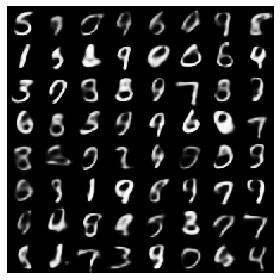

  2%|▏         | 7/400 [02:24<2:15:33, 20.70s/it]

obj_1: -122.9189224243164
obj_2: -178.9241485595703
Saved samples to ./pics/mnist_epoch_None_K_2_N_2_amortize_True.png


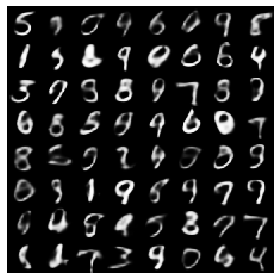

  2%|▏         | 8/400 [02:45<2:15:19, 20.71s/it]

In [ ]:
print_info = 1
for ep in tqdm(range(args.num_epoches)):
    for b_num, batch_train in enumerate(dataset.next_train_batch()): # cycle over batches
#         pdb.set_trace()
        mu, sigma = encoder(batch_train)
        u = args.std_normal.sample(mu.shape)
        z = mu + sigma * u # reparametrization trick
        z_hmc = z.detach()
        sum_log_sigma = torch.sum(torch.log(sigma), 1)
        ###### objective for phi
        ####
        log_p = target.get_logdensity(z=z, x=batch_train)
        log_q = args.std_normal.log_prob(u).sum(1) - sum_log_sigma
        obj_1 = torch.mean(log_p - log_q)
        (-obj_1).backward()
        optimizer_phi.step()
        optimizer_phi.zero_grad()
        optimizer_theta.zero_grad()
        ###### objective for theta
        ####
        p_hmc = args.std_normal.sample(mu.shape)
        
        for k in range(args.K):
            z_hmc, p_hmc, _, _, _, _ = HMC.make_transition(q_old=z_hmc, p_old=p_hmc, target_distr=target, x=batch_train)
        obj_2 = torch.mean(target.get_logdensity(z=z_hmc, x=batch_train))
        (-obj_2).backward()
        optimizer_theta.step()
        optimizer_theta.zero_grad()
    if ep % print_info == 0:
        print('obj_1:', obj_1.cpu().detach().item())
        print('obj_2:', obj_2.cpu().detach().item())
        with torch.no_grad():
            plot_digit_samples(get_samples(target.decoder, random_code), args)

In [ ]:
num_samples = 10000

z_0 = torch.distributions.Normal(
        loc=torch.zeros(args.z_dim, dtype=torchType, device=device),
        scale=torch.ones(args.z_dim, dtype=torchType, device=device)).sample([num_samples]).requires_grad_(True)

g_samples = decoder(z_0)[0].view(num_samples, -1)

In [ ]:
def get_jacobian(x, z):
    jacobian = torch.empty(x.shape[1], z.shape[1], device=device, dtype=torchType)
    for dim in range(x.shape[1]):
        jacobian[dim, :] = torch.mean(torch.autograd.grad(x[:, dim].sum(), z, retain_graph=True)[0], dim=0)
    return jacobian

In [ ]:
mean_jac = get_jacobian(g_samples, z_0)

In [ ]:
mean_jac.shape

In [ ]:
u, s ,v = torch.svd(mean_jac)

In [ ]:
plt.plot(s.cpu().detach().numpy())
plt.yscale('log')
plt.title('Singular values decay')
plt.xlabel('Dimension number')
plt.ylabel('Singular value');